In [1]:
import os
import random
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.wrappers import FlattenObservation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.distributions import DictDistribution

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F

MAX_NUM_FUNCTIONS = 2
MAX_INPUT = 5

/Users/matus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MyObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(MyObservationWrapper, self).__init__(env)
        self.observation_space = spaces.MultiDiscrete([2 for _ in range(env.max_num_functions * 2)] + [env.max_input for _ in range(env.max_num_functions * 2)])
            
    def reverse_observation(self, observation):
        return {
            "points": observation[:env.max_num_functions * 2],
            "features": observation[env.max_num_functions * 2:]
        }
    
    def observation(self, observation):
        return np.concatenate((observation["points"], observation["features"]), axis=0)

class MyActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(MyActionWrapper, self).__init__(env)
        self.action_space = spaces.MultiDiscrete([env.max_num_functions, env.max_input])
        
    def action(self, action):
        return {
            "function": action[0],
            "input": action[1]
        }

    def reverse_action(self, action):
        return np.array([action["function"], action["input"]])
    
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps} - Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    #if self.verbose > 0:
                    #    print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


In [3]:
class CustomExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space):
        super().__init__(observation_space, features_dim=120)

    def forward(self, observations):
        return observations

    
class CustomModule(nn.Module):
    def __init__(self):
        super(CustomModule, self).__init__()
        self.d_model = 128
        self.features_d = MAX_INPUT * 2
        self.action_history_d = 2 * 2
        self.fc1 = nn.Linear(self.features_d + self.action_history_d, self.d_model)
    
    def forward(self, observations):
        batch_dim = observations.size()[0]
    
        points = observations[:, :2 * 2 * MAX_NUM_FUNCTIONS].reshape(batch_dim, -1, self.action_history_d)
        features = observations[:, 2 * 2 * MAX_NUM_FUNCTIONS:].reshape(batch_dim, -1, self.features_d)
                
        x = torch.cat([features, points], dim=2)
        x = F.relu(self.fc1(x))
        x = torch.max(x, dim=1).values
        
        return x
    
    
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 128,
        last_layer_dim_vf: int = 128,
    ):
        super(CustomNetwork, self).__init__()
        
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        self.policy_net = nn.Sequential(
            CustomModule(),
            nn.Linear(last_layer_dim_pi, last_layer_dim_pi), nn.ReLU(),
            nn.Linear(last_layer_dim_pi, last_layer_dim_pi), nn.ReLU(),
            nn.Linear(last_layer_dim_pi, last_layer_dim_pi), nn.ReLU()
        )

        self.value_net = nn.Sequential(
            CustomModule(),
            nn.Linear(last_layer_dim_vf, last_layer_dim_vf), nn.ReLU(),
            nn.Linear(last_layer_dim_vf, last_layer_dim_vf), nn.ReLU(),
            nn.Linear(last_layer_dim_vf, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        
        p = self.policy_net(features)
        v = self.value_net(features)
        return p, v

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        p = self.policy_net(features)
        return p

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        v = self.value_net(features)
        return v


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            *args,
            **kwargs,
        )

        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [23]:
class DummyContractV2:
    def __init__(self, num_functions, features):
        self.num_functions = num_functions
        self.points = [0 for i in range(2 * num_functions)] #coverage
        
        assert(len(features) == 2 * self.num_functions)
        self.features = features
    
    def get_points_sum(self):
        return sum(self.points)
    
    def get_features(self):
        return self.features
        
    def call(self, fn_i, x):
        prev_score = self.get_points_sum()
        
        if fn_i < self.num_functions:
             
            if x == self.features[2 * fn_i]:
                self.points[2 * fn_i] = 1

            if x == self.features[2 * fn_i + 1]:
                self.points[2 * fn_i + 1] = 1
            
        score = self.get_points_sum()
        reward = score - prev_score
        reward = -1 if reward == 0 else reward
        return reward

class MyEnv(gym.Env):
    
    def __init__(self, max_num_functions, max_input):
        super(MyEnv, self).__init__()
        self.contract = None
        self.num_steps = None
        self.action_history = None
        
        self.max_num_functions = max_num_functions
        self.max_input = max_input
        self.action_history_size = 2 * max_num_functions
        
        self.observation_space = spaces.Dict({
            "points": spaces.MultiBinary(2 * max_num_functions), 
            "features": spaces.MultiDiscrete([max_input for i in range(2 * max_num_functions)])
        })
        
        self.action_space = spaces.Dict({
            "function": spaces.Discrete(max_num_functions), 
            "input": spaces.Discrete(max_input)
        })
    
    def create_observation(self):
        points = self.contract.points
        features = self.contract.features
        actions = self.action_history
        
        obs_points = np.zeros(self.observation_space["points"].shape, dtype=np.int8)
        obs_features = np.zeros(self.observation_space["features"].shape, dtype=np.float32)
        
        obs_points[0:len(points)] = points
        obs_features[0:len(features)] = features
                
        return {
            "points": obs_points, 
            "features": obs_features
        }
            
    def step(self, action):
        self.num_steps += 1
        fn_index, fn_input = action["function"], action["input"]
        
        prev_score = self.contract.get_points_sum()
        self.contract.call(fn_index, fn_input)
        score = self.contract.get_points_sum()
        reward = score - prev_score
        #reward = -1 if reward == 0 else reward
        
        max_score = self.contract.num_functions * 2
        done = self.num_steps == max_score or score == max_score
        self.action_history.append([fn_index, fn_input, reward])
        
        observation = self.create_observation()
        reward /= max_score
        
        info = {}

        return observation, reward, done, info

    def reset(self, new=False):
        if new or self.contract is None:
            num_functions = self.max_num_functions #random.randint(2, self.max_num_functions)

            features = self.observation_space["features"].sample().tolist()

            self.contract = DummyContractV2(num_functions, features[:2 * num_functions])
            self.num_steps = 0
            self.action_history = []

            return self.create_observation()
        
        else:
            self.num_steps = 0
            self.action_history = []
            features = self.contract.get_features()
            self.contract = DummyContractV2(len(features)//2, features)
            #self.contract.points = [0 for x in self.contract.points]
            return self.create_observation()
        
    def render(self, mode='console'):        
        raise NotImplementedError()

    def close(self):
        pass

env = MyEnv(max_num_functions=MAX_NUM_FUNCTIONS, max_input=MAX_INPUT)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [55]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

#Initiate new environment with a new DummyContract for which we need to find calls to maximise its coverage.
env = MyObservationWrapper(MyActionWrapper(MyEnv(max_num_functions=MAX_NUM_FUNCTIONS, max_input=MAX_INPUT)))
env = Monitor(env, log_dir)
env.reset()

print("features: [f0, f1, f2, f3] represent that function 0 needs to be called with f0, f1 and function 1 needs to be called with f2, f3")
print("Contract features:", env.contract.get_features())

policy_kwargs = {
    "features_extractor_class": CustomExtractor,
}

model = PPO(CustomActorCriticPolicy, env, verbose=0, policy_kwargs=policy_kwargs)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

features: [f0, f1, f2, f3] represent that function 0 needs to be called with f0, f1 and function 1 needs to be called with f2, f3
Contract features: [3, 1, 2, 2]


In [56]:
model.learn(total_timesteps=30000, callback=callback)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10000)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Num timesteps: 10000 - Best mean reward: -inf - Last mean reward per episode: 0.59
Num timesteps: 20000 - Best mean reward: 0.59 - Last mean reward per episode: 0.91
Num timesteps: 30000 - Best mean reward: 0.91 - Last mean reward per episode: 0.99
mean_reward:1.00 +/- 0.00


In [57]:
#Print the calls that were found by the training process.

#env = MyActionWrapper(MyObservationWrapper(MyEnv(max_num_functions=MAX_NUM_FUNCTIONS, max_input=MAX_INPUT)))
obs = env.reset()

while True:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f"action: {action[0]}, arg: {action[1]}, coverage: {obs[:len(obs)//2]}, features: {obs[len(obs)//2:]}, reward: {reward}, done: {done}")
    
    if done:
        break

action: 1, arg: 2, coverage: [0. 0. 1. 1.], features: [3. 1. 2. 2.], reward: 0.5, done: False
action: 0, arg: 1, coverage: [0. 1. 1. 1.], features: [3. 1. 2. 2.], reward: 0.25, done: False
action: 0, arg: 3, coverage: [1. 1. 1. 1.], features: [3. 1. 2. 2.], reward: 0.25, done: True


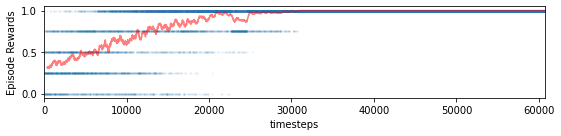

In [58]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "")

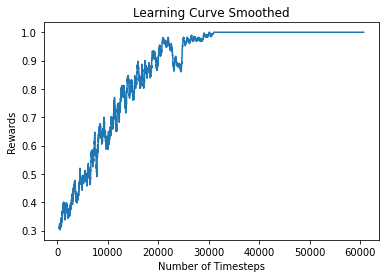

In [59]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results(log_dir)